## Linearized Likes

In [3]:
import pandas as pd
import pandahouse as ph
from scipy import stats
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
connection = {'host' : 'https://clickhouse.lab.karpov.courses',
              'database' : 'simulator_20220820',
              'user' : 'student',
              'password' : 'dpo_python_2020'
             }

query = '''
    SELECT user_id,
           countIf(user_id, action = 'like' ) as like,
           countIf(user_id, action = 'view' ) as view,
           like/view as CTR,
           exp_group
      FROM {db}.feed_actions
      WHERE toDate(time) >= '2022-07-13' and toDate(time) <= '2022-07-19'
      GROUP BY user_id, exp_group
      '''

df = ph.read_clickhouse(query, connection = connection)

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

- Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
- Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
- После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
- Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

**Задача**

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

#### Небольшой разведочный анализ

In [5]:
df_g = df.query('exp_group == 0 | exp_group == 3')
df_g1 = df.query('exp_group == 1 | exp_group == 2')

In [4]:
df_g, df_g1

(       user_id  like  view       CTR  exp_group
 0       115383     9    30  0.300000          3
 2       123580    13    48  0.270833          3
 7        30319    21   110  0.190909          0
 9       118359     7    38  0.184211          3
 11        7626    14    39  0.358974          0
 ...        ...   ...   ...       ...        ...
 50130   110492     4    17  0.235294          0
 50143   136299    35   116  0.301724          0
 50144    27030     8    39  0.205128          0
 50145   122758    30   198  0.151515          3
 50147   122190    19    65  0.292308          3
 
 [20048 rows x 5 columns],
        user_id  like  view       CTR  exp_group
 1        18392     7    32  0.218750          1
 3       131473    14   134  0.104478          2
 5        32420    26   128  0.203125          2
 6        24239    40    90  0.444444          2
 8        27443     2    29  0.068966          1
 ...        ...   ...   ...       ...        ...
 50138    21697     2    22  0.090909   

In [5]:
df_g.groupby('exp_group')['CTR'].agg(['mean', 'median', 'count', 'sum'])

,mean,median,count,sum
exp_group,,,,
0,0.215950,0.202899,9999,2159.280550
3,0.232624,0.220339,10049,2337.637663


In [6]:
df_g1.groupby('exp_group')['CTR'].agg(['mean', 'median', 'count', 'sum'])

,mean,median,count,sum
exp_group,,,,
1,0.215605,0.203125,10079,2173.078747
2,0.214419,0.142857,9952,2133.900610


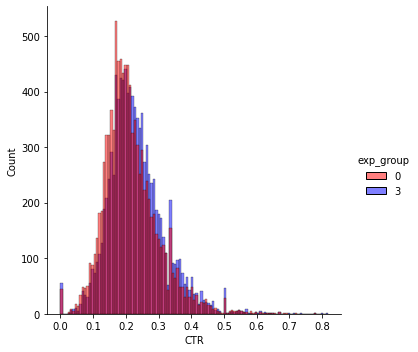

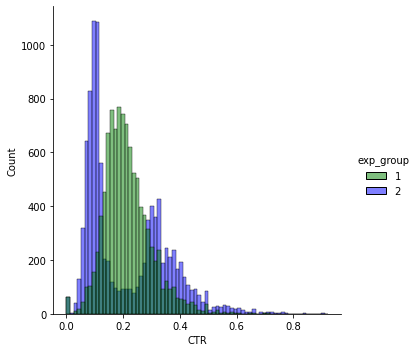

In [7]:
sns.displot(x='CTR',
            hue ='exp_group',
            data=df_g,
            palette = ['r', 'b']);

sns.displot(x='CTR',
            hue ='exp_group',
            data=df_g1,
            palette = ['g', 'b']);

<AxesSubplot:xlabel='exp_group', ylabel='CTR'>

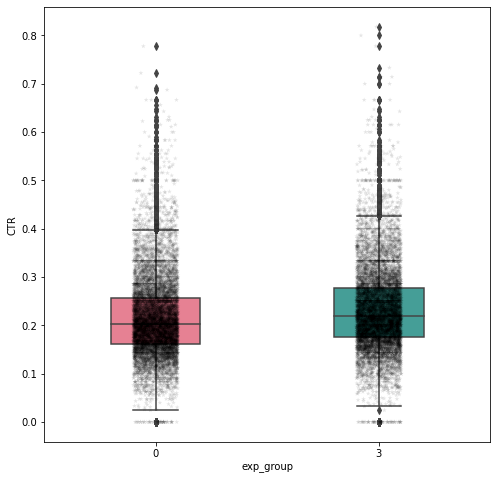

In [8]:
fig = plt.subplots(1,1, figsize=(8, 8))

sns.boxplot(data = df_g,
            x = 'exp_group',
            y = 'CTR',
            palette = 'husl',
            width=0.4)
sns.stripplot(data = df_g, 
                        x= "exp_group",
                        y = "CTR",
                        marker="*",
                        alpha=0.1,
                        color="black")

#### Метод линеаризации

In [15]:
gr_sm_0 = df_g[df_g.exp_group == 0].copy()
gr_sm_3 = df_g[df_g.exp_group == 3].copy()
gr_sm_1 = df_g1[df_g1.exp_group == 1].copy()
gr_sm_2 = df_g1[df_g1.exp_group == 2].copy()

In [16]:
CTR_glob = gr_sm_0['like'].sum() / gr_sm_0['view'].sum()
Linear_0 = gr_sm_0['like'] - CTR_glob * gr_sm_0['view']
Linear_3 = gr_sm_3['like'] - CTR_glob * gr_sm_3['view']

In [33]:
CTR_glob = gr_sm_1['like'].sum() / gr_sm_1['view'].sum()
Linear_1 = gr_sm_1['like'] - CTR_glob * gr_sm_1['view']
Linear_2 = gr_sm_2['like'] - CTR_glob * gr_sm_2['view']

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

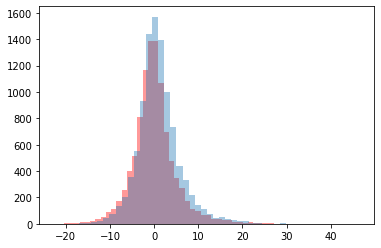

In [29]:
sns.distplot(Linear_0,
             kde = False,
             color = 'r')
sns.distplot(Linear_3,
             kde = False)

<AxesSubplot:>

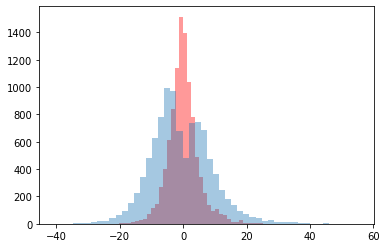

In [34]:
sns.distplot(Linear_1,
             kde = False,
             color = 'r')
sns.distplot(Linear_2,
             kde = False)

#### t-test

Первый тест идет на линеаризованных данных, а второй - на обычных.

In [35]:
stats.ttest_ind(Linear_0, Linear_3, equal_var = False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

In [20]:
stats.ttest_ind(df_g.query('exp_group == 0')['CTR'], df_g.query('exp_group == 3')['CTR'], equal_var = False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [36]:
stats.ttest_ind(Linear_1, Linear_2, equal_var = False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037712e-10)

In [38]:
stats.ttest_ind(df_g1.query('exp_group == 1')['CTR'], df_g1.query('exp_group == 2')['CTR'], equal_var = False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

Действительно, очень круто. Особенно наглядно видна разница в работе метрики на 1 и 2 группах, где изначально t-test не мог уловить разницу в выборках.

**Функция линеаризации**

In [7]:
def linearization_likes(likes_0, views_0, likes_1, views_1):
    """
    Функция линеаризации лайков
    --------------------
    Параметры:
    likes_0 - лайки пользователей контрольной группы
    views_0 - просмотры пользователей контрольной группы
    likes_1 - лайки пользователей экспериментальной группы
    views_1 - просмотры пользователей экспериментальной группы

    Функция возвращает: 
    Linear_0, Linear_1- линеаризированные лайки обеих групп
    """
    
    CTR_glob = (likes_0.sum() / views_0.sum())
    Linear_0 = likes_0 - CTR_glob * views_0
    Linear_1 = likes_1 - CTR_glob * views_1
    return Linear_0, Linear_1

In [8]:
A = linearization_likes(gr_sm_0['like'], gr_sm_0['view'], gr_sm_3['like'], gr_sm_3['view'])

In [18]:
B = linearization_likes(gr_sm_1['like'], gr_sm_1['view'], gr_sm_2['like'], gr_sm_2['view'])